In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [133]:
class Neural_Network:
    def __init__(self,data,r1,r2,layer_dims):
        data=data.sample(frac=1).reset_index(drop=True)

        self.r1=r1
        self.r2=r2
        
        l1=int(self.r1*data.shape[0])
        self.X_train=data.iloc[0:l1,1:].to_numpy().T
        self.y_train=data.iloc[0:l1,0].to_numpy()
        self.X_train=self.X_train/255
        
        l2=int((self.r1+self.r2)*data.shape[0])
        self.X_cv=data.iloc[l1:l2,1:].to_numpy().T
        self.y_cv=data.iloc[l1:l2,0].to_numpy()
        self.X_cv=self.X_cv/255
        
        self.X_test=data.iloc[l2:,1:].to_numpy().T
        self.y_test=data.iloc[l2:,0].to_numpy()
        self.X_test=self.X_test/255

        self.y_train_encoded=self.one_hot_encoding(self.y_train)
        self.y_cv_encoded=self.one_hot_encoding(self.y_cv)
        self.y_test_encoded=self.one_hot_encoding(self.y_test)
        
        self.layer_dims=layer_dims

        self.initialize_parameters()

        self.v={}
        for l in range(1,len(self.layer_dims)):
            self.v["dW"+str(l)]=np.zeros((self.layer_dims[l],self.layer_dims[l-1]))
            self.v["db"+str(l)]=np.zeros((self.layer_dims[l],1))

        self.s={}
        for l in range(1,len(self.layer_dims)):
            self.s["dW"+str(l)]=np.zeros((self.layer_dims[l],self.layer_dims[l-1]))
            self.s["db"+str(l)]=np.zeros((self.layer_dims[l],1))

    def one_hot_encoding(self,y):
        num_cat=len(np.unique(y))
        y_new=np.zeros((len(y),num_cat))
        for i in range(len(y)):
            j=int(y[i])
            y_new[i,j]+=1
        return y_new.T

    def initialize_parameters(self):
        self.parameters={}
        for l in range(1,len(self.layer_dims)):
            self.parameters["W"+str(l)]=np.random.randn(self.layer_dims[l],self.layer_dims[l-1])*np.sqrt(2/self.layer_dims[l])
            self.parameters["b"+str(l)]=np.zeros((self.layer_dims[l],1))
        return self.parameters

    def relu_activation(self,Z):
        A=np.maximum(0,Z)
        return A

    def softmax_activation(self,Z):
        e_Z=np.exp(Z-np.max(Z,axis=0,keepdims=True))
        A=e_Z/np.sum(e_Z,axis=0,keepdims=True)
        return A

    def forward_activation(self,A_prev,W,b,activation):
        Z=np.dot(W,A_prev)+b
        cache1=(A_prev,W,b)
        cache2=(Z)
        if(activation=="relu"):
            A=self.relu_activation(Z)
        elif(activation=="softmax"):
            A=self.softmax_activation(Z)
            
        cache=(cache1,cache2)
        return A,cache

    def forward_prop(self,X):
        caches=[]
        A=X
        L=len(self.parameters)//2
        for l in range(1,L):
            A_prev=A
            W_l=self.parameters["W"+str(l)]
            b_l=self.parameters["b"+str(l)]
            A,temp_cache=self.forward_activation(A_prev,W_l,b_l,"relu")
            caches.append(temp_cache)
        WL=self.parameters["W"+str(L)]
        bL=self.parameters["b"+str(L)]
        AL,cache_L=self.forward_activation(A,WL,bL,"softmax")
        caches.append(cache_L)
        # AL=np.clip(AL,1e-7,1-1e-7)
        return AL,caches

    def sparse_categorical_cross_entropy(self,AL,Y):
        loss=np.multiply(np.log(AL),Y)
        cost=-np.sum(loss)/Y.shape[1]
        for w in [self.parameters["W"+str(l)] for l in range(1,len(self.parameters)//2+1)]:
            cost+=self.lambda_*(np.linalg.norm(w,ord='fro')**2)/(2*Y.shape[1])
        return cost

    def activation_backward(self,dA,cache,activation,Y):
        cache1,cache2=cache
        A_prev,W,b=cache1
        Z=cache2
        if(activation=="relu"):
            dZ=np.zeros((Z.shape))
            dZ=np.multiply((Z>0)*1,dA)
            # dZ[np.where(Z>0)]=np.multiply(dA[np.where(Z>0)],1)
            # dZ[np.where(Z<=0)]=np.multiply(dA[np.where(Z<=0)],0)
            dW=np.dot(dZ,A_prev.T)/A_prev.shape[1]
            db=np.sum(dZ,axis=1,keepdims=True)/A_prev.shape[1]
            dA_prev=np.dot(W.T,dZ)
        elif(activation=="softmax"):
            A=self.softmax_activation(Z)
            dZ=A-Y
            dW=np.dot(dZ,A_prev.T)/A_prev.shape[1]
            db=np.sum(dZ,axis=1,keepdims=True)/A_prev.shape[1]
            dA_prev=np.dot(W.T,dZ)
            
        return dA_prev,dW,db

    def backward_prop(self,X,Y,caches):
        self.gradients={}
        m=X.shape[1]
        L=len(caches) #list ke andar L tuples
        # dAL=-np.divide(Y,AL)+np.divide((1-Y),(1-AL))
        dAL=0
        cache_L=caches[L-1]
        W_L=caches[L-1][0][1]
        dA_prev_L,dW_L,db_L=self.activation_backward(dAL,cache_L,"softmax",Y)
        self.gradients["dA"+str(L-1)]=dA_prev_L
        self.gradients["dW"+str(L)]=dW_L +(self.lambda_*W_L/m)
        self.gradients["db"+str(L)]=db_L
    
        for l in reversed(range(L-1)):
            cache_l =caches[l]
            W_l=cache_l[0][1]
            dA_prev_l, dW_l, db_l=self.activation_backward(self.gradients["dA"+str(l+1)],cache_l,"relu",Y)
            self.gradients["dA" + str(l)] = dA_prev_l
            self.gradients["dW" + str(l + 1)]=dW_l+(self.lambda_*W_l/m)
            self.gradients["db" + str(l + 1)]=db_l 

    def gradient_descent(self):
        L=len(self.parameters)//2
        for l in range(L):
            self.parameters["W"+str(l+1)]-=self.alpha*self.gradients["dW"+str(l+1)]
            self.parameters["b"+str(l+1)]-=self.alpha*self.gradients["db"+str(l+1)]

    def gradient_descent_with_momentum(self):
        L=len(self.parameters)//2
        for l in range(L):
            self.v["dW"+str(l+1)]=self.beta*(self.v["dW"+str(l+1)])+(1-self.beta)*self.gradients["dW"+str(l+1)]
            self.v["db"+str(l+1)]=self.beta*(self.v["db"+str(l+1)])+(1-self.beta)*self.gradients["db"+str(l+1)]

            self.parameters["W"+str(l+1)]=self.parameters["W"+str(l+1)]-self.alpha*self.v["dW"+str(l+1)]
            self.parameters["b"+str(l+1)]=self.parameters["b"+str(l+1)]-self.alpha*self.v["db"+str(l+1)]

    def RMSprop(self):
        L=len(self.parameters)//2
        for l in range(L):
            self.s["dW"+str(l+1)]=self.beta*self.s["dW"+str(l+1)]+(1-self.beta)*(self.gradients["dW"+str(l+1)])
            self.s["db"+str(l+1)]=self.beta*self.s["db"+str(l+1)]+(1-self.beta)*(self.gradients["db"+str(l+1)])

            self.parameters["W"+str(l+1)]=self.parameters["W"+str(l+1)]-self.alpha*self.s["dW"+str(l+1)]
            self.parameters["b"+str(l+1)]=self.parameters["b"+str(l+1)]-self.alpha*self.s["db"+str(l+1)]
            
    def Adam(self,n):
        L=len(self.parameters)//2
        self.epsilon=1e-8
        for l in range(L):
            self.v["dW"+str(l+1)]=self.beta1*self.v["dW"+str(l+1)]+(1-self.beta1)*self.gradients["dW"+str(l+1)]
            # self.v["dW"+str(l+1)]=self.v["dW"+str(l+1)]/(1-self.beta1**n)

            self.v["db"+str(l+1)]=self.beta1*self.v["db"+str(l+1)]+(1-self.beta1)*self.gradients["db"+str(l+1)]
            # self.v["db"+str(l+1)]=self.v["db"+str(l+1)]/(1-self.beta1**n)
            
            self.s["dW"+str(l+1)]=self.beta2*self.s["dW"+str(l+1)]+(1-self.beta2)*(self.gradients["dW"+str(l+1)]**2)
            # self.s["dW"+str(l+1)]=self.s["dW"+str(l+1)]/(1-self.beta2**n)

            self.s["db"+str(l+1)]=self.beta2*self.s["db"+str(l+1)]+(1-self.beta2)*(self.gradients["db"+str(l+1)]**2)
            # self.s["db"+str(l+1)]=self.s["db"+str(l+1)]/(1-self.beta2**n)

            self.parameters["W"+str(l+1)]=self.parameters["W"+str(l+1)]-self.alpha*(self.v["dW"+str(l+1)]/(np.sqrt(self.s["dW"+str(l+1)])+self.epsilon))
            self.parameters["b"+str(l+1)]=self.parameters["b"+str(l+1)]-self.alpha*(self.v["db"+str(l+1)]/(np.sqrt(self.s["db"+str(l+1)])+self.epsilon))

    def model(self,optimization,alpha,lambda_,alpha_decay,num_epochs,mini_batch_size):
        self.J_hist=[]
        self.alpha=alpha
        self.lambda_=lambda_
        self.alpha_decay=alpha_decay
        self.num_epochs=num_epochs
        self.mini_batch_size=mini_batch_size
        
        X=self.X_train
        Y=self.y_train_encoded
        
        AL,caches=self.forward_prop(X)
        initial_cost=self.sparse_categorical_cross_entropy(AL,Y)
        print(f'Initial Cost: {initial_cost}')
        self.J_hist.append(initial_cost)
        optimizer=optimization[0]
        
        if(optimizer=='momentum'):
            self.beta=optimization[1]
        elif(optimizer=='RMSprop'):
            self.beta=optimization[1]
        elif(optimizer=='Adam'):
            self.beta1=optimization[1]
            self.beta2=optimization[2]
            
        num_complete_mini_batches=int(X.shape[1]/self.mini_batch_size)
        
        for i in range(self.num_epochs):
            self.alpha=self.alpha/(1+self.alpha_decay*self.num_epochs)
            for t in range(num_complete_mini_batches):
                mini_batch_X=X[:,t*self.mini_batch_size:(t+1)*self.mini_batch_size]
                mini_batch_Y=Y[:,t*self.mini_batch_size:(t+1)*self.mini_batch_size]
                AL,caches=self.forward_prop(mini_batch_X)
                cost=self.sparse_categorical_cross_entropy(AL,mini_batch_Y)
                self.backward_prop(mini_batch_X,mini_batch_Y,caches)
                if(optimizer=='gradient_descent'):
                    self.gradient_descent()
                elif(optimizer=='momentum'):
                    self.gradient_descent_with_momentum()
                elif(optimizer=='RMSprop'):
                    self.RMSprop()
                elif(optimizer=='Adam'):
                    self.Adam(n=0)
                if(X.shape[1]%num_complete_mini_batches!=0):
                    mini_batch_X=X[:,(int(X.shape[1]/self.mini_batch_size)*self.mini_batch_size):]
                    mini_batch_Y=Y[:,(int(Y.shape[1]/self.mini_batch_size)*self.mini_batch_size):]
                    AL,caches=self.forward_prop(mini_batch_X)
                    cost=self.sparse_categorical_cross_entropy(AL,mini_batch_Y)
                    self.backward_prop(mini_batch_X,mini_batch_Y,caches)
                    if(optimizer=='gradient_descent'):
                        self.gradient_descent()
                    elif(optimizer=='momentum'):
                        self.gradient_descent_with_momentum()
                    elif(optimizer=='RMSprop'):
                        self.RMSprop()
                    elif(optimizer=='Adam'):
                        self.Adam(n=0)
            self.J_hist.append(cost)
            print(f'Cost after epoch {i+1}: {cost}')

    def prediction(self,X):
        AL=self.forward_prop(X)[0]
        y_pred=np.argmax(AL,axis=0)
        return y_pred   

    def plot_cost(self):
        plot_x=np.arange(len(self.J_hist))
        plot_y=np.array(self.J_hist)
        plt.plot(plot_x,plot_y)
        plt.xlabel("No. of epochs")
        plt.ylabel("Cost")

    def confusion_matrix(self,y_pred,y):
        tp=np.sum((y_pred==1)&(y==1))
        tn=np.sum((y_pred==0)&(y==0))
        fp=np.sum((y_pred==1)&(y==0))
        fn=np.sum((y_pred==0)&(y==1))
        cmat=np.array([[tp,fp],[fn,tn]])
        return cmat

    def accuracy_one_hot(self,y_pred,y):
        c=self.confusion_matrix(y_pred,y)
        tp=c[0,0]
        tn=c[1,1]
        fp=c[0,1]
        fn=c[1,0]
        accuracy=(tp+tn)/(tp+tn+fp+fn)
        return accuracy

    def F1_score(self,y_pred,y):
        c=self.confusion_matrix(y_pred,y)
        tp=c[0,0]
        tn=c[1,1]
        fp=c[0,1]
        fn=c[1,0]
        precision=tp/(tp+fp)
        recall=tp/(tp+fn)
        F1=(2*precision*recall)/(precision+recall)
        return F1

    def accuracy(self,y_pred,y):
        accuracy=np.sum(y_pred==y)/y.shape[0]
        return accuracy

In [3]:
train_data=pd.read_csv('Classification_train.csv')
train_data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [137]:
np.random.seed(420)

In [138]:
NN=Neural_Network(train_data,r1=0.8,r2=0.1,layer_dims=[784,512,256,128,10])

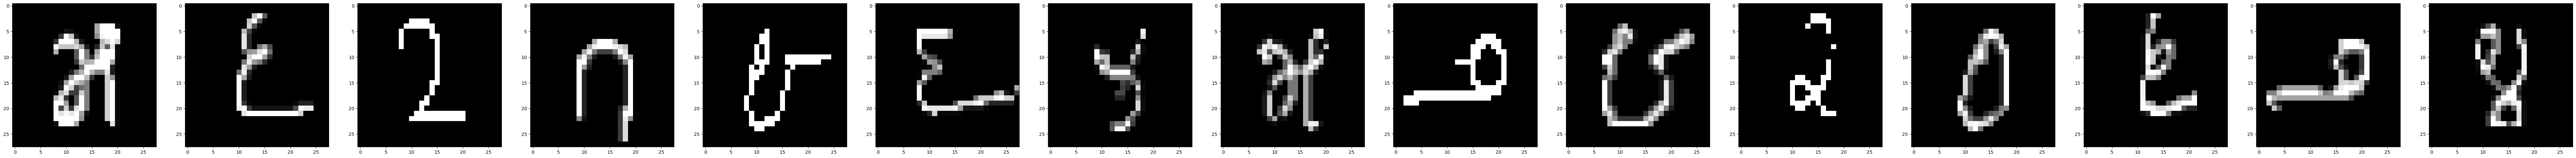

In [20]:
fig,axis=plt.subplots(ncols=15,figsize=(100,10))
for i in range(15):
    image=np.array(NN.X_train[:,i],dtype=float)
    pxl =image.reshape((28, 28))
    axis[i].imshow(pxl, cmap='gray')

Initial Cost: 4.757739175084508
Cost after epoch 1: 0.03620407907272781
Cost after epoch 2: 0.0023180535847824348
Cost after epoch 3: 0.0010073157810963807
Cost after epoch 4: 0.0004206583514310204
Cost after epoch 5: 0.0011599035774297031
Cost after epoch 6: 0.0005706943721332389
Cost after epoch 7: 0.0005378396417725278
Cost after epoch 8: 0.000877531348242334
Cost after epoch 9: 0.0001064011825024477
Cost after epoch 10: 0.0011234247713245691
Cost after epoch 11: 8.828228246847808e-05
Cost after epoch 12: 3.215461716832833e-05
Cost after epoch 13: 3.6298492573758587e-05
Cost after epoch 14: 2.0139466178791995e-05
Cost after epoch 15: 0.028319875571114317
Cost after epoch 16: 6.14599034728637e-05
Cost after epoch 17: 8.716731957624725e-05
Cost after epoch 18: 0.00063503544153592
Cost after epoch 19: 4.410785101449471e-05
Cost after epoch 20: 4.460522617591503e-05
Cost after epoch 21: 0.00012287972319163632
Cost after epoch 22: 4.973440819150726e-06
Cost after epoch 23: 5.520340037214

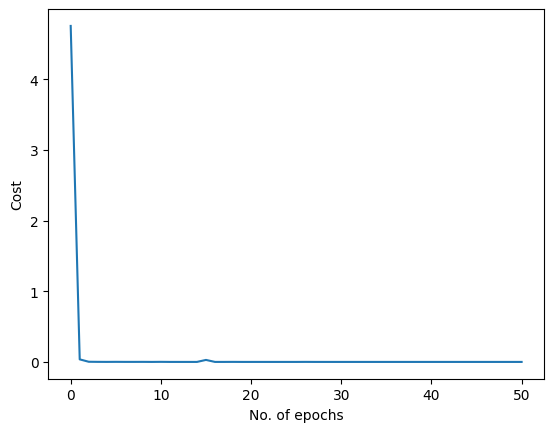

In [139]:
optimization=('Adam',0.9,0.999)
NN.model(optimization,alpha=0.001,lambda_=0,alpha_decay=0,num_epochs=50,mini_batch_size=64)
NN.plot_cost()

In [140]:
NN.ytrain_pred=NN.prediction(NN.X_train)
NN.ycv_pred=NN.prediction(NN.X_cv)
NN.ytest_pred=NN.prediction(NN.X_test)

In [141]:
print(f'Accuracy for training dataset: {NN.accuracy(NN.ytrain_pred,NN.y_train)}')

Accuracy for training dataset: 1.0


In [142]:
print(f'Accuracy for cross validation dataset: {NN.accuracy(NN.ycv_pred,NN.y_cv)}')

Accuracy for cross validation dataset: 0.9916666666666667


In [143]:
print(f'Accuracy for test dataset: {NN.accuracy(NN.ytest_pred,NN.y_test)}')

Accuracy for test dataset: 0.988


In [97]:
np.random.seed(420)
NN1=Neural_Network(train_data,r1=0.8,r2=0.1,layer_dims=[784,512,256,128,10])

In [98]:
optimization=('RMSprop',0.999)
NN1.model(optimization,alpha=0.1,lambda_=0,alpha_decay=0,num_epochs=10,mini_batch_size=64)

Initial Cost: 4.757739175084508
Cost after epoch 1: 0.2482088820929391
Cost after epoch 2: 0.06287701669460304
Cost after epoch 3: 0.06910033658763445
Cost after epoch 4: 0.04104753701364941
Cost after epoch 5: 0.013498865094261975
Cost after epoch 6: 0.021230691006121613
Cost after epoch 7: 0.009120206117163927
Cost after epoch 8: 0.02286148284081902
Cost after epoch 9: 0.01759357628214979
Cost after epoch 10: 0.010060267519226852


In [99]:
NN1.ytrain_pred=NN1.prediction(NN1.X_train)
NN1.ycv_pred=NN1.prediction(NN1.X_cv)
NN1.ytest_pred=NN1.prediction(NN1.X_test)

In [100]:
print(f'Accuracy for cross validation dataset: {NN1.accuracy(NN1.ycv_pred,NN1.y_cv)}')

Accuracy for cross validation dataset: 0.983


In [44]:
np.random.seed(420)
NN2=Neural_Network(train_data,r1=0.8,r2=0.1,layer_dims=[784,512,256,128,10])

In [45]:
optimization=('momentum',0.9)
NN2.model(optimization,alpha=0.5,lambda_=0,alpha_decay=0,num_epochs=30,mini_batch_size=64)

Initial Cost: 4.757739175084508
Cost after epoch 1: 0.06316749570541098
Cost after epoch 2: 0.04621606769107119
Cost after epoch 3: 0.0017593883197558802
Cost after epoch 4: 0.0007858960627486604
Cost after epoch 5: 0.00036872905197113875
Cost after epoch 6: 0.22198286955269464
Cost after epoch 7: 0.00026255472449348866
Cost after epoch 8: 0.0003108302982371601
Cost after epoch 9: 9.589670526912113e-05
Cost after epoch 10: 3.8094714972216703e-05
Cost after epoch 11: 3.1536046244859454e-05
Cost after epoch 12: 2.1374474776660907e-05
Cost after epoch 13: 1.796181422620752e-05
Cost after epoch 14: 1.563408981016753e-05
Cost after epoch 15: 1.3924231238816951e-05
Cost after epoch 16: 1.2628731311156006e-05
Cost after epoch 17: 1.1553132147338817e-05
Cost after epoch 18: 1.0688515128998783e-05
Cost after epoch 19: 9.9186526022719e-06
Cost after epoch 20: 9.295430614546684e-06
Cost after epoch 21: 8.744744153852847e-06
Cost after epoch 22: 8.25975947632531e-06
Cost after epoch 23: 7.83505477

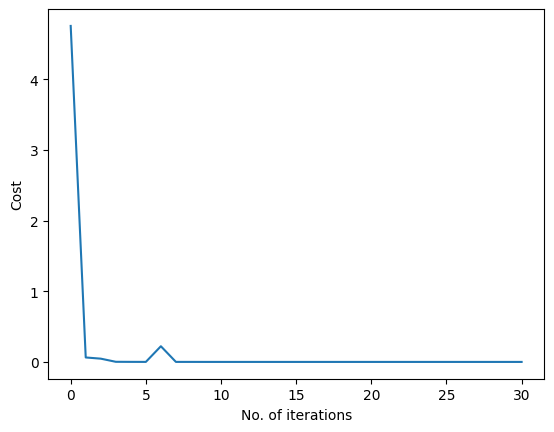

In [144]:
NN2.plot_cost()

In [46]:
NN2.ytrain_pred=NN2.prediction(NN2.X_train)
NN2.ycv_pred=NN2.prediction(NN2.X_cv)
NN2.ytest_pred=NN2.prediction(NN2.X_test)

In [47]:
print(f'Accuracy for cross validation dataset: {NN2.accuracy(NN2.ycv_pred,NN2.y_cv)}')

Accuracy for cross validation dataset: 0.992


In [57]:
print(f'Accuracy for test dataset: {NN2.accuracy(NN2.ytest_pred,NN2.y_test)}')

Accuracy for test dataset: 0.989


In [61]:
np.random.seed(420)
NN3=Neural_Network(train_data,r1=0.8,r2=0.1,layer_dims=[784,512,256,128,10])

In [62]:
optimization=('momentum',0.9)
NN3.model(optimization,alpha=0.5,lambda_=0,alpha_decay=0,num_epochs=100,mini_batch_size=64)

Initial Cost: 4.757739175084508
Cost after epoch 1: 0.06316749570541098
Cost after epoch 2: 0.04621606769107119
Cost after epoch 3: 0.0017593883197558802
Cost after epoch 4: 0.0007858960627486604
Cost after epoch 5: 0.00036872905197113875
Cost after epoch 6: 0.22198286955269464
Cost after epoch 7: 0.00026255472449348866
Cost after epoch 8: 0.0003108302982371601
Cost after epoch 9: 9.589670526912113e-05
Cost after epoch 10: 3.8094714972216703e-05
Cost after epoch 11: 3.1536046244859454e-05
Cost after epoch 12: 2.1374474776660907e-05
Cost after epoch 13: 1.796181422620752e-05
Cost after epoch 14: 1.563408981016753e-05
Cost after epoch 15: 1.3924231238816951e-05
Cost after epoch 16: 1.2628731311156006e-05
Cost after epoch 17: 1.1553132147338817e-05
Cost after epoch 18: 1.0688515128998783e-05
Cost after epoch 19: 9.9186526022719e-06
Cost after epoch 20: 9.295430614546684e-06
Cost after epoch 21: 8.744744153852847e-06
Cost after epoch 22: 8.25975947632531e-06
Cost after epoch 23: 7.83505477

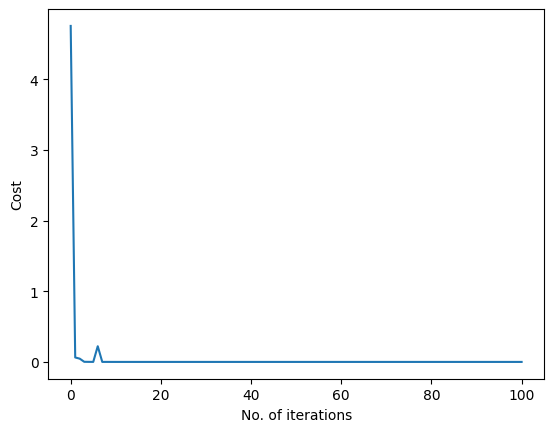

In [145]:
NN3.plot_cost()

In [63]:
NN3.ytrain_pred=NN3.prediction(NN3.X_train)
NN3.ycv_pred=NN3.prediction(NN3.X_cv)
NN3.ytest_pred=NN3.prediction(NN3.X_test)

In [64]:
print(f'Accuracy for cross validation dataset: {NN3.accuracy(NN3.ycv_pred,NN3.y_cv)}')

Accuracy for cross validation dataset: 0.9923333333333333


In [65]:
print(f'Accuracy for test dataset: {NN3.accuracy(NN3.ytest_pred,NN3.y_test)}')

Accuracy for test dataset: 0.9893333333333333


In [126]:
np.random.seed(420)
NN4=Neural_Network(train_data,r1=0.8,r2=0.1,layer_dims=[784,512,256,128,10])

In [127]:
optimization=('gradient_descent',)
NN4.model(optimization,alpha=0.25,lambda_=0,alpha_decay=0,num_epochs=50,mini_batch_size=64)

Initial Cost: 4.757739175084508
Cost after epoch 1: 0.05100252949054107
Cost after epoch 2: 0.015373665484578126
Cost after epoch 3: 0.013199259533835798
Cost after epoch 4: 0.006977509535614068
Cost after epoch 5: 0.0013421169171064181
Cost after epoch 6: 0.0016064835987302474
Cost after epoch 7: 0.0006337789302026789
Cost after epoch 8: 0.00023489325202551145
Cost after epoch 9: 0.00016252690532821042
Cost after epoch 10: 0.00011669938950109056
Cost after epoch 11: 9.54324486474864e-05
Cost after epoch 12: 8.34138524950052e-05
Cost after epoch 13: 7.493355277080806e-05
Cost after epoch 14: 6.623228205995993e-05
Cost after epoch 15: 6.132684462089871e-05
Cost after epoch 16: 5.6184815540549016e-05
Cost after epoch 17: 5.295450395726502e-05
Cost after epoch 18: 4.97764542741283e-05
Cost after epoch 19: 4.6199610408422365e-05
Cost after epoch 20: 4.397317087874856e-05
Cost after epoch 21: 4.132362478617768e-05
Cost after epoch 22: 3.920290433552651e-05
Cost after epoch 23: 3.69213766840

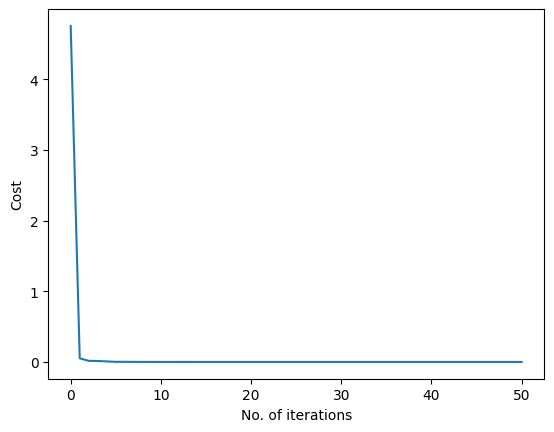

In [136]:
NN4.plot_cost()

In [128]:
NN4.ytrain_pred=NN4.prediction(NN4.X_train)
NN4.ycv_pred=NN4.prediction(NN4.X_cv)
NN4.ytest_pred=NN4.prediction(NN4.X_test)

In [130]:
print(f'Accuracy for training dataset: {NN4.accuracy(NN4.ytrain_pred,NN4.y_train)}')

Accuracy for training dataset: 1.0


In [129]:
print(f'Accuracy for cross validation dataset: {NN4.accuracy(NN4.ycv_pred,NN4.y_cv)}')

Accuracy for cross validation dataset: 0.9886666666666667


In [131]:
print(f'Accuracy for test dataset: {NN4.accuracy(NN4.ytest_pred,NN4.y_test)}')

Accuracy for test dataset: 0.989


In [146]:
test_data=pd.read_csv('Classification_test.csv')
test_data.head()

,ID,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,15795,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,860,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,5390,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,11964,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,11284,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [150]:
test_x=test_data.iloc[:,1:].to_numpy().T

In [151]:
al=NN4.forward_prop(test_x/255)[0]

In [152]:
test_y=np.argmax(al,axis=0)

In [154]:
df = pd.DataFrame({'ID': test_data.iloc[:,0], 'label': test_y})
df.to_csv('result_neural.csv')